In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segmentation import patch_extraction
import torch
from classification.model import SAlexNet
import pandas as pd
from IPython.display import clear_output

/home/msouda/.pyenv/versions/3.9.18/envs/face_detection/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Patch extraction via SLIC and super pixel classification

100%|██████████| 798/798 [00:03<00:00, 207.14it/s]


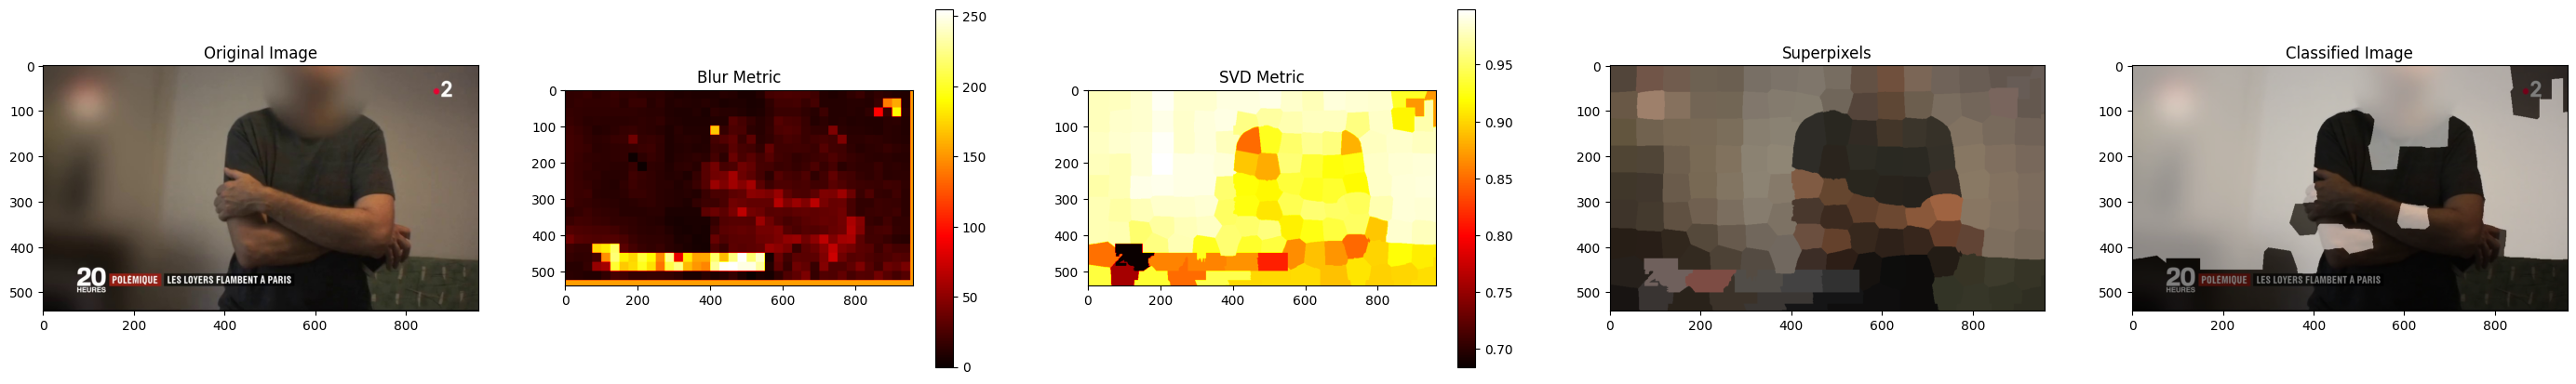

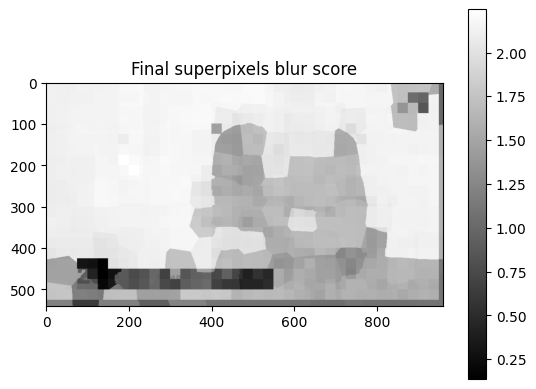

10 squares of size 180 found


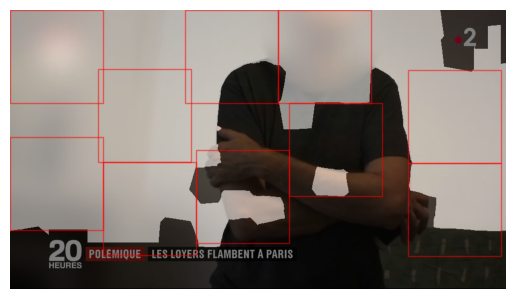

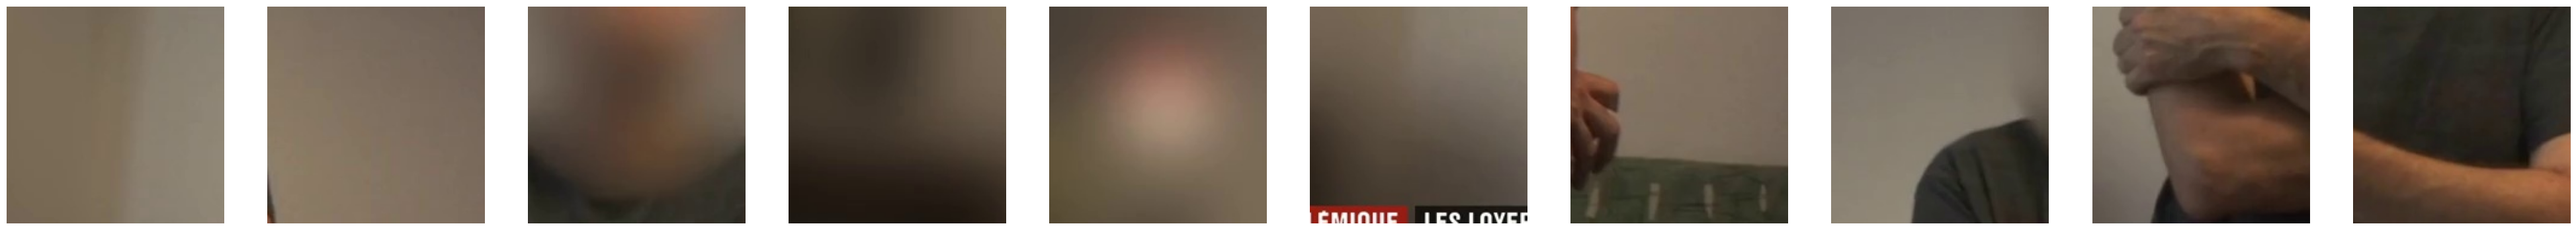

In [15]:
img_path = '/home/msouda/Datasets/true_anonymized/fr2_20180718T200950/fr2_20180718T200950_s054_f0.jpg'
img = Image.open(img_path)

segments, patch_labels, classes, SVD, D, max_squares, squares, _classes = patch_extraction.produce_patches(img)


## Patch extraction and classification

In [16]:
model = SAlexNet(num_classes=5, input_size=128)
print(f"Simplified AlexNet model with parameters: {sum(p.numel() for p in model.parameters())}")
model.load_state_dict(torch.load('/home/msouda/Workspace/models/SFA8_bis.pth'))

Simplified AlexNet model with parameters: 1342245


<All keys matched successfully>

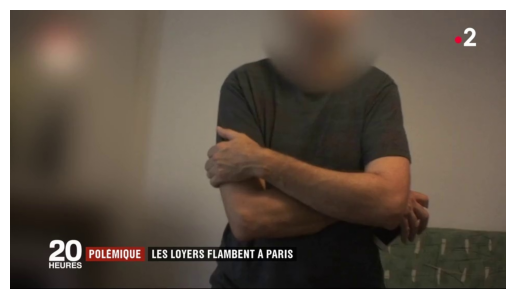

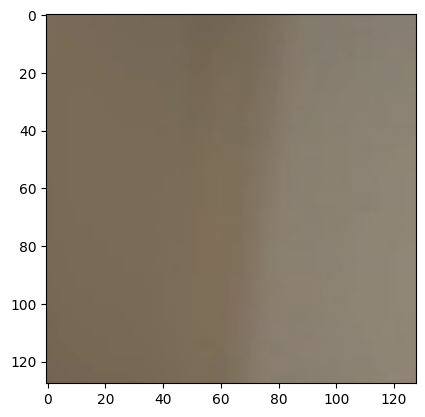

tensor([[ 353.9502,   77.8389, -432.5556,  304.1422, -303.5828]])
Patch 0 prediction: 0


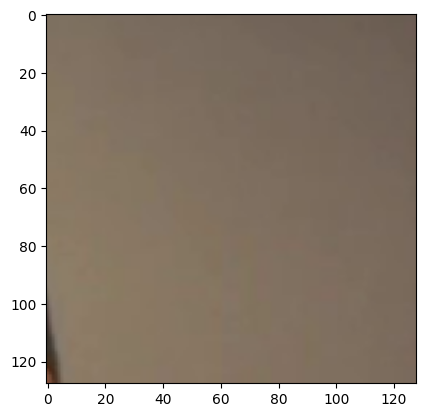

tensor([[ 366.1934,   79.0835, -420.2575,  258.6082, -283.6826]])
Patch 1 prediction: 0


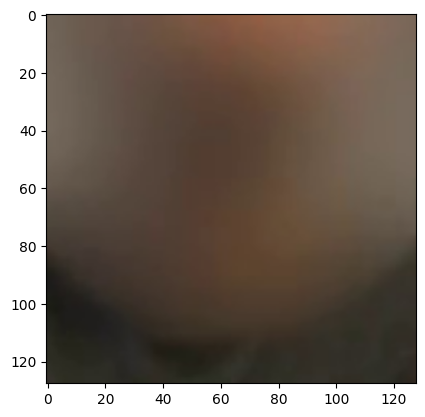

tensor([[ 150.9044,   64.2750, -254.7224,  207.0540, -167.4748]])
Patch 2 prediction: 3


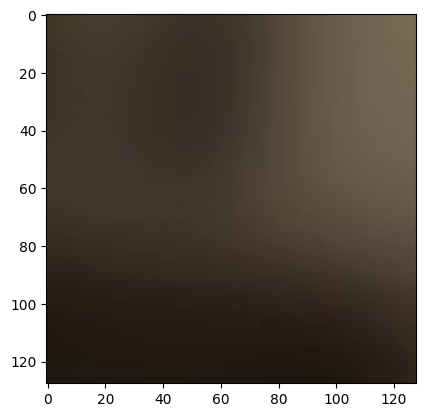

tensor([[ 171.3613,   70.5396, -213.8671,  135.0719, -163.1526]])
Patch 3 prediction: 0


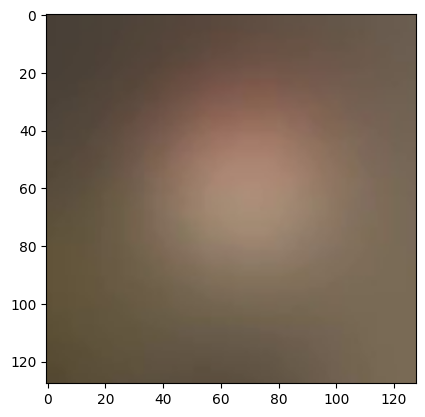

tensor([[ 269.3809,  117.6602, -384.2313,  286.4302, -289.4232]])
Patch 4 prediction: 3


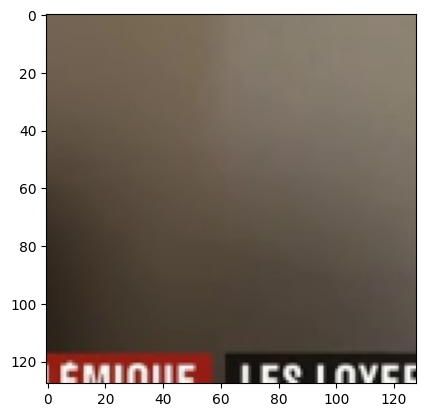

tensor([[ 283.9239,  142.0173, -529.4821,  262.4048, -159.4208]])
Patch 5 prediction: 0


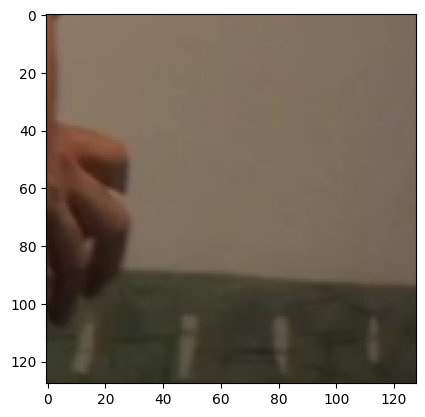

tensor([[ 494.2434,  181.9247, -413.4378,  -16.2130, -246.6992]])
Patch 6 prediction: 0


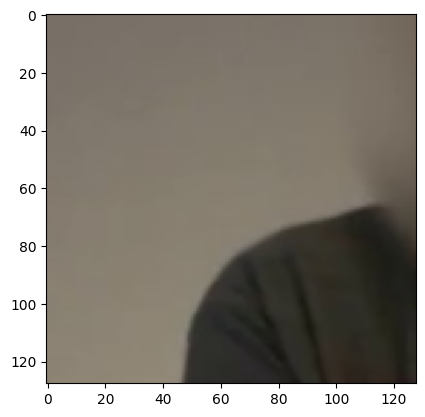

tensor([[ 428.7361,  199.3935, -447.7447,  118.4556, -299.8170]])
Patch 7 prediction: 0


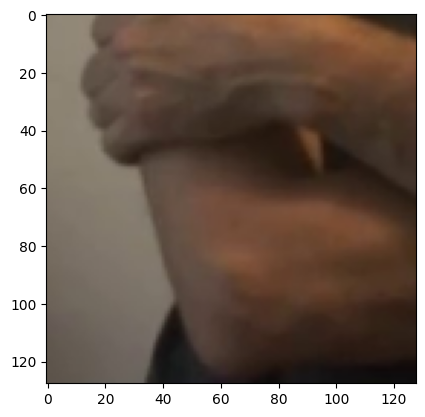

tensor([[ 544.7510,   62.3960, -480.6416,  -15.7390, -110.1542]])
Patch 8 prediction: 0


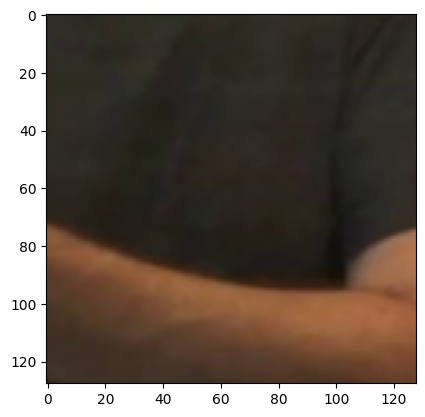

tensor([[ 353.7158,  -14.7488, -348.3246,  109.4101, -100.3603]])
Patch 9 prediction: 0


In [17]:
patch_pred = {}
model.eval()
plt.imshow(img)
plt.axis('off')
plt.show()

#PREDICTIONS : blur_dict = {'clear': 0, 'motion': 1, 'defocus': 2, 'gaussian': 3, 'anonym':4}

with torch.no_grad():
    for i, square in enumerate(squares):
        
        square = cv2.resize(square, (128, 128))
        #square = cv2.resize(square[60:100, 60:100], (128, 128))
        plt.imshow(square)
        plt.show()
        #display_fourier_spectrum(cv2.cvtColor(square, cv2.COLOR_RGB2GRAY))
        square = torch.tensor(square).permute(2, 0, 1).unsqueeze(0).float()
        output = model(square)
        print(output)
        print(f"Patch {i} prediction: {output[0,:].argmax().item()}")

100%|██████████| 493/493 [00:01<00:00, 378.63it/s]


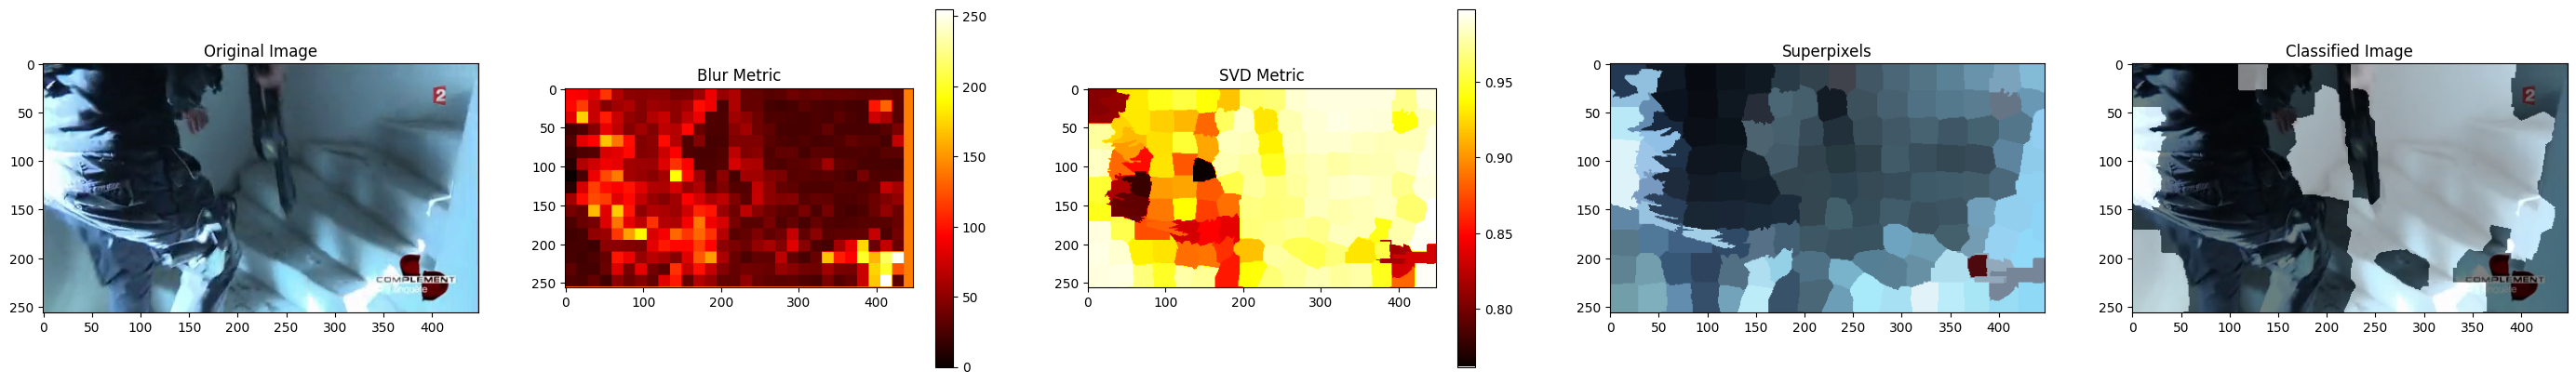

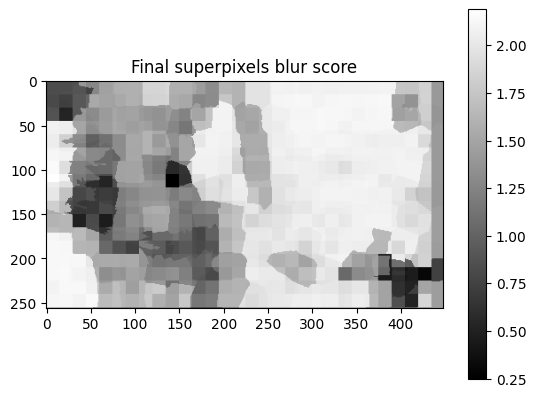

5 squares of size 128 found


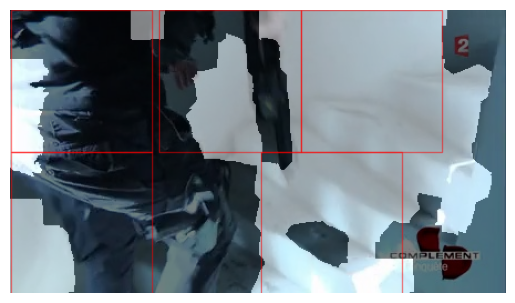

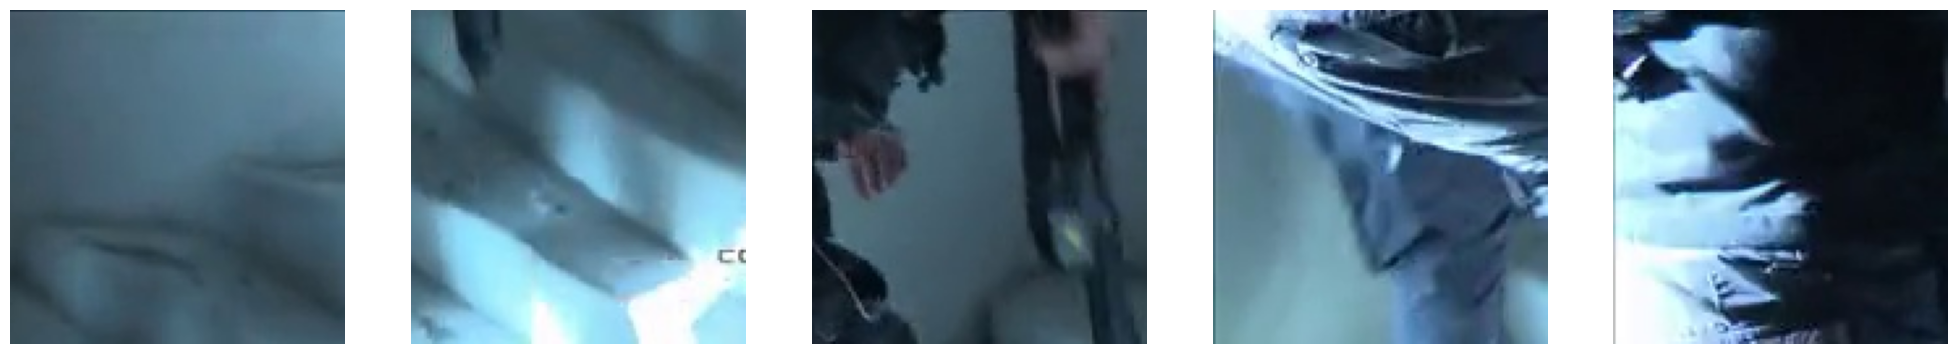

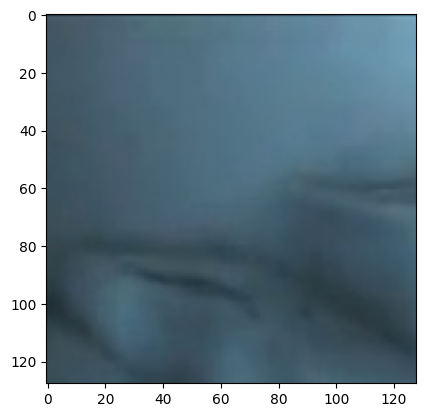

tensor([[ 204.1220,  119.8168, -105.2259, -133.4370,  -84.8263]])
Patch 0 prediction: 0


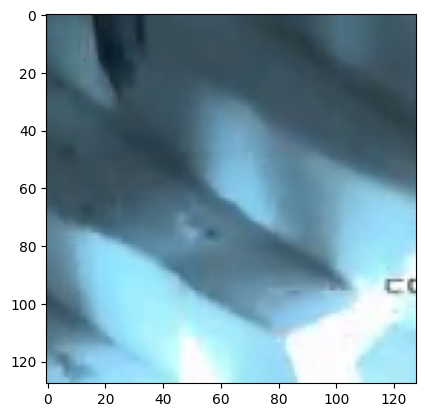

tensor([[ 288.8730,   76.9984, -168.7367, -113.8784,  -81.9375]])
Patch 1 prediction: 0


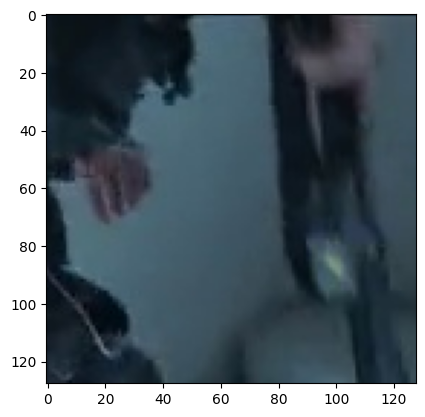

tensor([[ 420.5016,  162.1765, -321.4740,   39.8538, -300.2056]])
Patch 2 prediction: 0


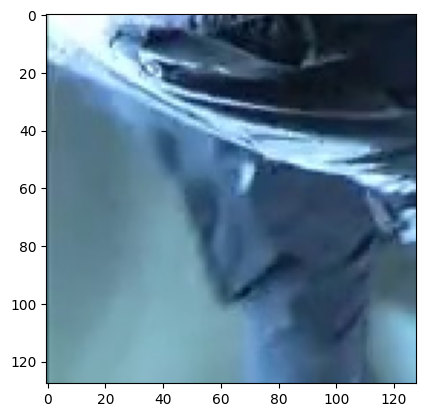

tensor([[ 613.1769,  138.9853, -316.4679, -464.6403,   29.3382]])
Patch 3 prediction: 0


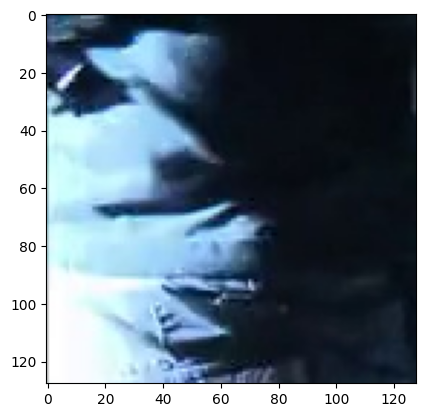

tensor([[ 609.7897,  472.5607, -262.4854, -783.7441,  -35.4179]])
Patch 4 prediction: 0


In [11]:
#PREDICTIONS sur plusieurs images
patch_pred = {}
model.eval()
count = 0
n_images = 20
annotations = pd.read_csv('/home/msouda/Datasets/true_anonymized/annotations.csv', header=None, names=['filename', 'label']).assign(filename=lambda x: '/home/msouda/Datasets/true_anonymized/' + x['filename']).sample(n = n_images).reset_index(drop=True)
with torch.no_grad():
    while count < n_images:
    #i = np.random.randint(0, len(synth))
        
        img_path = annotations.loc[count, 'filename']
        #img_path = '/home/msouda/Datasets/caltech-101/101_ObjectCategories_blurred_4/accordion_image_0001.jpg'
        img = Image.open(img_path)
        # plt.imshow(img)
        # plt.axis('off')
        # plt.show()
        # np.array(img).shape
        count += 1
        segments, patch_labels, classes, SVD, D, max_squares, squares, _classes = patch_extraction.produce_patches(img)
        predictions = []
        for i, square in enumerate(squares):
        
            square = cv2.resize(square, (128, 128))
            #square = cv2.resize(square[60:100, 60:100], (128, 128))
            plt.imshow(square)
            plt.show()
            square = torch.tensor(square).permute(2, 0, 1).unsqueeze(0).float()
            output = model(square)
            print(output)
            print(f"Patch {i} prediction: {output[0,:].argmax().item()}")
            predictions.append(output[0,:].argmax().item())
        
        patch_pred[count] = {
            'img_path': img_path,
            'max_squares': max_squares,
            'predictions': predictions,
        }
        clear_output(wait=True)
        